In [1]:
import pandas as pd
import numpy as np
import pathlib
import json
import matplotlib.pyplot as plt
import requests
import pathlib

# Load data

In [2]:
data_json = pathlib.Path("data.json")
if not data_json.exists():
    contents = requests.get("https://github.com/dfinity/dre/raw/main/docs/trustworthy-metrics/data.json").text
    data_json.write_text(contents)
data = json.load(pathlib.Path("data.json").open())
data_flat = []
for subnet_id, subnet_data in data.items():
    node_last_entry = {}
    for day in subnet_data:
        ts_nanos = day["timestamp_nanos"]
        day_data = day["node_metrics"]
        for entry in day_data:
            node_id = entry["node_id"]
            # Calculate diff (increase) from the entry with the previous timestamp
            prev_entry = node_last_entry.get(node_id, {})
            if entry["num_blocks_total"] == 0 or not prev_entry:
                entry["num_blocks_diff"] = 0
                entry["num_block_failures_diff"] = 0
            else:
                entry["num_blocks_diff"] = entry["num_blocks_total"] - prev_entry.get("num_blocks_total", 0)
                entry["num_block_failures_diff"] = entry["num_block_failures_total"] - prev_entry.get("num_block_failures_total", 0)
            node_last_entry[node_id] = entry
            entry["subnet_id"] = subnet_id
            entry["timestamp_nanos"] = ts_nanos
            data_flat.append(entry)
df = pd.json_normalize(data_flat)
df["date"] = pd.to_datetime(df["timestamp_nanos"]).dt.round("D")
df["node_failed_rounds_percent"] = (df["num_block_failures_diff"] * 100 / (df["num_blocks_diff"]+df["num_block_failures_diff"])).replace(np.inf, 0).fillna(0)

# In how many block rounds per day did a node fail to be productive (successfully propose a block in time)

In [3]:
df["node_failed_rounds_percent"] = (df["num_block_failures_diff"] * 100 / (df["num_blocks_diff"]+df["num_block_failures_diff"])).replace(np.inf, 0).fillna(0)

# Show the DataFrame sorted by "node_failed_rounds_percent"

In [4]:
df.sort_values("node_failed_rounds_percent")

,node_id,num_blocks_total,num_block_failures_total,num_blocks_diff,num_block_failures_diff,subnet_id,timestamp_nanos,date,node_failed_rounds_percent
0,jvqnq-6jnty-tr3ml-izvma-e5w6e-s3rfx-w4wir-mwcs...,3379,416,0,0,4zbus-z2bmt-ilreg-xakz4-6tyre-hsqj4-slb4g-zjwq...,1700611199687713062,2023-11-22,0.0
12709,g4avo-ecrmg-ki3ol-dxah7-zksar-suefa-26fco-fudv...,1177,1,0,0,pzp6e-ekpqk-3c5x7-2h6so-njoeq-mt45d-h3h6c-q3mx...,1700783999803104413,2023-11-24,0.0
26006,m3h5f-hvglm-f7xdh-sx7oa-fqktz-x6fnr-5b2uj-gkt4...,338430,355,7279,0,w4asl-4nmyj-qnr7c-6cqq4-tkwmt-o26di-iupkq-vx4k...,1704585599845929185,2024-01-07,0.0
26007,5djxc-oflqt-exy2d-ka2dg-nndl7-pzw2n-sgquq-75ca...,333074,4350,7095,0,w4asl-4nmyj-qnr7c-6cqq4-tkwmt-o26di-iupkq-vx4k...,1704585599845929185,2024-01-07,0.0
12710,ou5js-fk2zz-pi2ra-jjavx-2ld2m-3l3rh-asgas-tof7...,1171,9,0,0,pzp6e-ekpqk-3c5x7-2h6so-njoeq-mt45d-h3h6c-q3mx...,1700783999803104413,2023-11-24,0.0
...,...,...,...,...,...,...,...,...,...
16737,a2e7m-evijx-geoc6-o5j6s-h45ye-f3hxj-w7dfi-25e2...,177851,26166,0,6281,lhg73-sax6z-2zank-6oer2-575lz-zgbxx-ptudx-5kor...,1703203199087851013,2023-12-22,100.0
18753,r5i76-zvt2k-ssuo3-on5tn-gl7fr-vvx3g-mits2-inmh...,227984,44366,0,6636,csyj4-zmann-ys6ge-3kzi6-onexi-obayx-2fvak-zers...,1703894399768341484,2023-12-30,100.0
30198,6j3rt-inrpe-arelp-4qmfz-3pz6v-kax72-sbwgx-mxcs...,226535,43844,0,6791,fuqsr-in2lc-zbcjj-ydmcw-pzq7h-4xm2z-pto4i-dcye...,1703980799703895382,2023-12-31,100.0
18818,r5i76-zvt2k-ssuo3-on5tn-gl7fr-vvx3g-mits2-inmh...,227984,77802,0,6679,csyj4-zmann-ys6ge-3kzi6-onexi-obayx-2fvak-zers...,1704326399776384834,2024-01-04,100.0


# Count number of days per node, for which the node failed to be productive in 10% or more block rounds

In [5]:
df[df["node_failed_rounds_percent"] > 10].groupby("node_id").node_id.count().sort_values()

node_id
dkx5h-i5d56-xeb37-uldi5-dlgmp-atrom-gyfn7-edeih-i5ph6-2cquy-dqe     1
k3ree-ug5ci-l5q6u-wci73-ascqg-pb3a6-znui5-py5n7-2if4r-nnehy-3ae     1
wazkf-2xehg-y26ek-2uq64-pkrbh-6frmq-4q7lf-5gaya-44q4p-v5r5z-cqe     1
b44r4-u77ay-myhhv-d6d75-jusik-b7ry2-g6ms5-6okxm-tumyx-rjm4g-4ae     1
xbsjm-f7kbx-wrerv-ponbs-e3kjp-pvt6d-lgjfv-kolpw-c4j3y-to5pe-7qe     1
                                                                   ..
cx4uq-65xot-2xtcl-gqqeg-nbxkp-t4kvl-ixzul-ndhrm-wg2xx-u2kef-kae    16
7hznr-gsays-zrzek-tj7px-p2kbq-blvlx-wmbi4-kxkyv-syl62-vdofe-iae    17
ul75e-6e3ls-pno2p-y3plc-cd2gq-dfnw4-56woc-s45vm-ipu6u-lotli-uae    18
o2ejh-i3l5b-tawnx-6vane-ek7hi-apzj2-d2vid-j5dro-xityu-sszcb-gqe    19
r5i76-zvt2k-ssuo3-on5tn-gl7fr-vvx3g-mits2-inmhe-ohouc-ebdik-3qe    21
Name: node_id, Length: 92, dtype: int64

# Check for impossible data in the DataFrame: give records for which more than 100% of rounds were non-productive (should be empty always)

In [6]:
df[df["node_failed_rounds_percent"] > 100]

,node_id,num_blocks_total,num_block_failures_total,num_blocks_diff,num_block_failures_diff,subnet_id,timestamp_nanos,date,node_failed_rounds_percent


# Plots

## Plot all records in which nodes were unproductive for more than 10% of time

<Figure size 640x480 with 0 Axes>

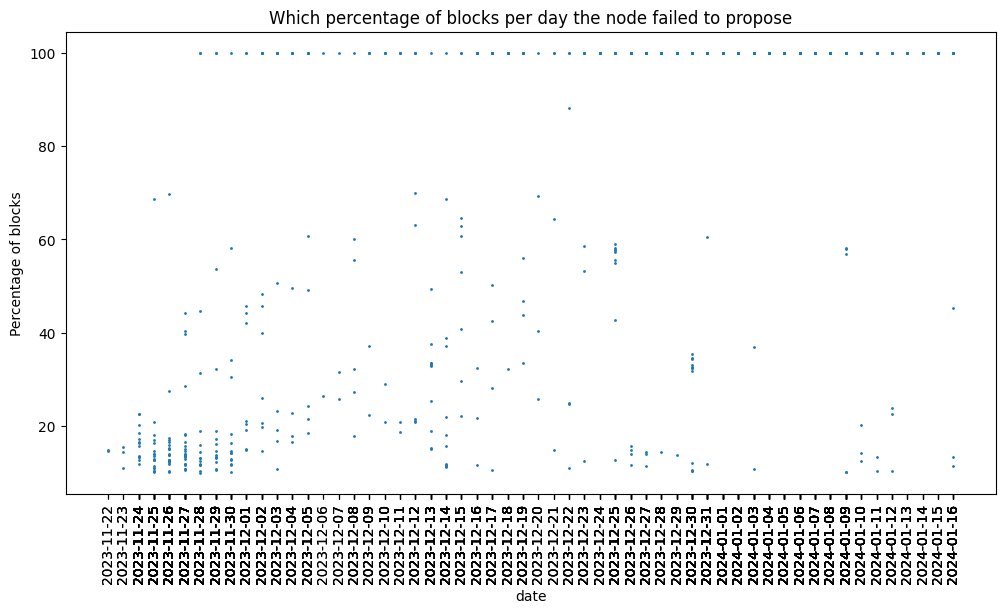

In [7]:
plt.figure()
df10 = df[df["node_failed_rounds_percent"] > 10]
ax = df10.plot(kind="scatter", x='date', y='node_failed_rounds_percent', ylabel="Percentage of blocks", title="Which percentage of blocks per day the node failed to propose", figsize=(12, 6), s=1)
plt.xticks(df10["date"], rotation=90)
plt.show()

## Plot percentage of failed block rounds for a particular node id

In [8]:
from ipywidgets import interact, widgets

node_ids_widget = widgets.Combobox(
    placeholder='Type a node id',
    options=list(df["node_id"].unique()),
    description='Combobox:',
    ensure_option=True,
    disabled=False
)

# display(node_ids_widget)

@interact(node_id = node_ids_widget)
def plot_node_id(node_id):
    if node_id:
        df_node = df[df["node_id"] == node_id]
        df_node.plot(kind="scatter", x='date', y='node_failed_rounds_percent', ylabel="Percentage of blocks", title="Percentage of blocks for which node failed to propose a block", figsize=(12, 6), s=1)
        plt.xticks(df_node["date"], rotation=90)
        plt.show()


interactive(children=(Combobox(value='', description='Combobox:', ensure_option=True, options=('jvqnq-6jnty-tr…

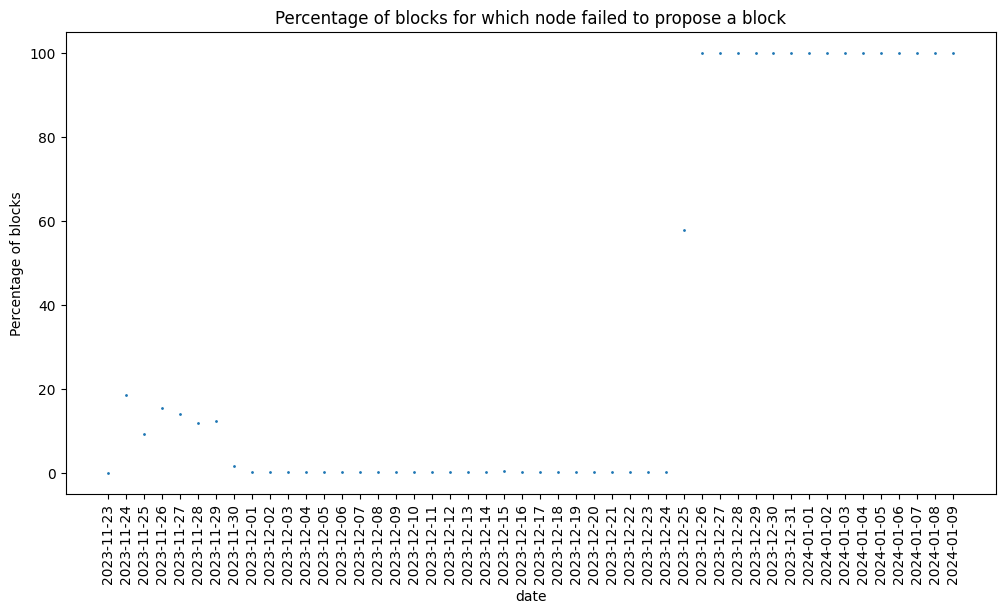

In [9]:
df_node = df[df["node_id"] == "r5i76-zvt2k-ssuo3-on5tn-gl7fr-vvx3g-mits2-inmhe-ohouc-ebdik-3qe"]
df_node.plot(kind="scatter", x='date', y='node_failed_rounds_percent', ylabel="Percentage of blocks", title="Percentage of blocks for which node failed to propose a block", figsize=(12, 6), s=1)
plt.xticks(df_node["date"], rotation=90)
plt.show()